# Practicum differentiaalvergelijkingen: De Lorenz Attractor

## Importeren packages

In [1]:
using Plots
using Distributed
using PyCall
using PyPlot
const plt = PyPlot
ioff()
using3D()
#pygui(true)

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\style\core.py:201: UserWarning: In C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\beaver_color_theme.mplstyle: Bad val "'" on line #1
	"axes.prop_cycle : '#d8d8d8', '#969696', '#cc0000', '#33b2b2'"
	in file "C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\beaver_color_theme.mplstyle"
	Key axes.prop_cycle: ''' is not a valid cycler construction: EOL while scanning string literal (<string>, line 1)
  warnings.warn(message)


Voeg extra 'workers' toe om berekeningen parallel te kunnen runnen

In [2]:
addprocs(9);
@everywhere begin
    using BenchmarkTools
    using LinearAlgebra
    using SharedArrays
    using Printf
end

### Importeren python packages

In [3]:
@pyimport sympy as sp
@pyimport scipy.linalg as lin
@pyimport numpy as np
@pyimport matplotlib as mpl
const col = mpl.colors;

C:\ProgramData\Miniconda3\lib\site-packages\sympy\core\decorators.py:38: SymPyDeprecationWarning: 

C, including its class ClassRegistry, has been deprecated since SymPy
1.0. It will be last supported in SymPy version 1.0. Use direct
imports from the defining module instead. See
https://github.com/sympy/sympy/issues/9371 for more info.

  _warn_deprecation(wrapped, 3)


## definieren functies en variabelen

Gradiënt implementeert de differentiaalvergelijking. Merk op dat alles binnen een @everywhere enviroment gewraped zit zodat de functies beschikbaar zijn voor alle workers

### dynamische functies (args meegeven aan gradient)

In [4]:
# definieer functies en variabelen voor alle workers
@everywhere begin
    function gradient(t0::Float64, X::Array{Float64, 1}, arg::Array{Float64})
        (x, y, z) = X
        (sigma, r, b) = arg

        dx = -sigma*x+sigma*y
        dy = r*x-y-x*z
        dz = -b*z+x*y

        return [dx, dy, dz]
    end

    function euler(f, X0, h, n, arg)
        x = zeros(Float64, 3, n)
        x[:, 1] = x0

        for i in 2:n
            x[:, i] = x[:, i-1] + h .* f(0., x[:, i-1], arg)
        end
        return x
    end
    
    # gebruikt de methode van Runge-Kata van orde 4 om een benaderende 
    # oplossing te geven van het autonoom stelsel X'=f(X), met beginvoorwaarde x0
    # stapgrootte h en n stappen
    function RK4(f, x0, h, n, arg)
        x = zeros(Float64, 3, n)
        x[:, 1] = x0

        for i in 2:n
            k1 = f(0., x[:, i-1], arg)
            k2 = f(0., x[:, i-1] + h * k1/2, arg)
            k3 = f(0., x[:, i-1] + h * k2/2, arg)
            k4 = f(0., x[:, i-1] + h * k3, arg)

            x[:, i] = x[:, i-1] + h/6 * (k1+2*k2+2*k3+k4)
        end
        return x
    end
end

### statische varianten (enkel de waarden uit de opgave in gradient)

In [5]:
# definieer functies en variabelen voor alle workers
# sigma = 10, r = 28, b = 8/3
@everywhere begin
    function gradient_s(t0::Float64, X::Array{Float64, 1})
        (x, y, z) = X

        dx = -10.0*x+10.0*y
        dy = 28.0*x-y-x*z
        dz = -8/3*z+x*y

        return [dx, dy, dz]
    end

    function euler_s(f, X0, h, n)
        x = zeros(Float64, 3, n)
        x[:, 1] = X0

        for i in 2:n
            x[:, i] = x[:, i-1] + h .* f(0., x[:, i-1])
        end
        return x
    end
    
    function euler2_s(f, X0, h, n)
        x = zeros(Float64, 3, n)
        x[:, 1] = X0

        for i in 2:n
            k1 = f(0., x[:, i-1])
            k2 = f(0., x[:, i-1] + h*k1)
            x[:, i] = x[:, i-1] + h*(k1+k2)/2
        end
        return x
    end
    
    # gebruikt de methode van Runge-Kata van orde 4 om een benaderende oplossing te geven van het autonoom stelsel X'=f(X), met beginvoorwaarde x0
    # stapgrootte h en n stappen
    function RK4_s(f, X0, h, n)
        x = zeros(Float64, 3, n)
        x[:, 1] = X0

        for i in 2:n
            k1 = f(0., x[:, i-1])
            k2 = f(0., x[:, i-1] + h*k1/2)
            k3 = f(0., x[:, i-1] + h*k2/2)
            k4 = f(0., x[:, i-1] + h*k3)

            x[:, i] = x[:, i-1] + h/6 .* (k1+2*k2+2*k3+k4)
        end
        return x
    end
end

### Andere functies

Functie om afstand van lijn tot punt te berekenen

In [6]:
@everywhere begin
    #=
    berekent de afstand van de rechte opgespannen door de punten beginP en endP
    tot het punt point 
    begin, end en point moeten 1d vectoren van dezelfde dimensie zijn
    returns: Float64 
    =#
    function dist_line_point(beginP::Array{Float64, 1}, endP::Array{Float64, 1}, point::Array{Float64, 1})
        return norm(cross(endP-beginP, beginP-point))/ norm((endP-beginP))
    end
    
    #=
    berekent de orthogonale projectie van het punt point op de rechte opgespannen door 
    beginP en endP
    =#
    function orth_projection(beginP, endP, point)
        P = point
        P0= beginP
        v = P-P0
        s = endP - beginP
        I = fill(1., 3, 3)
        projectie = (dot(v, s) / dot(s,s))*s
        return projectie + P0
    end
end

### initializeren variabelen

In [7]:
@everywhere begin
    # initiële condities en parameters voor elke methode
    x0 = [-13.763610682134, -19.578751942452, 27]
    he = 10^-5
    he2 = 5*10^-4
    hr = 10^-4
    # het tijdsinterval om over te integreren
    d=2
    # het aantal stappen om te zetten
    ne = ceil(Int64, d/he)
    ne2 = ceil(Int64, d/he2)
    nr = ceil(Int64, d/hr)
    args = [10., 28., 8/3]
    
    # variabelen voor parallele bewerkingen
    num = 3
    X0 = [x0 + i/10*fill(1., 3) for i in 0:num-1]
    (GRAD, GRAD_S, He, He2, Hr, Ne, Ne2, Nr, Args) = fill.([gradient, gradient_s, he, he2, hr, ne, ne2, nr, args], 3)
end

## Oefening 2

In [8]:
t, x, y, z = sp.symbols("t, x, y, z")
sp.init_printing()

sigma=10
r = 28
b = 8/3
dx = -sigma*x+sigma*y
dy = r*x-y-x*z
dz = -b*z+x*y

PyObject x*y - 2.66666666666667*z

Bepaal de kritieke punten

In [9]:
kritieke_punten = sp.solve([dx, dy, dz], (x, y, z))
vars = [x, y, z]
funcs = [dx, dy, dz]
(A, B, O) = (kritieke_punten[1], kritieke_punten[3], kritieke_punten[2])
sp.pprint(A)
sp.pprint(B)
sp.pprint(O)

(-8.48528137423857, -8.48528137423857, 27.0)
(8.48528137423857, 8.48528137423857, 27.0)
(0.0, 0.0, 0.0)


Functie om de Jacobiaan numeriek uit te rekenen

In [10]:
function num_jacobian(funcs, args, sub)
    return [[sp.diff(fun, arg)[:subs](sub) for arg in args] for fun in funcs]
end;

Reken de Jacobiaan uit in de kritieke punten

In [11]:
subA = [vars[i] => A[i] for i in 1:3];
subB = [vars[i] => B[i] for i in 1:3];
subO = [vars[i] => O[i] for i in 1:3];
JA = num_jacobian(funcs, vars, subA);
JB = num_jacobian(funcs, vars, subB);
JO = num_jacobian(funcs, vars, subO);

In [12]:
sp.pprint(JA)
sp.pprint(JB)
sp.pprint(JO)

[[-10, 10, 0], [1.0, -1, 8.48528137423857], [-8.48528137423857, -8.48528137423
857, -2.66666666666667]]
[[-10, 10, 0], [1.0, -1, -8.48528137423857], [8.48528137423857, 8.485281374238
57, -2.66666666666667]]
[[-10, 10, 0], [28, -1, 0], [0.0, 0.0, -2.66666666666667]]


Bereken de eigenvectoren en bijhorende eigenwaarden van de Jacobiaan in de kritieke punten

In [13]:
Ja = np.matrix(JA, dtype=np.float64);
eigA = eigen(Ja)

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
eigenvalues:
3-element Array{Complex{Float64},1}:
 -13.854577914596042 + 0.0im              
 0.09395562396468593 + 10.19450522092785im
 0.09395562396468593 - 10.19450522092785im
eigenvectors:
3×3 Array{Complex{Float64},2}:
  0.855665+0.0im  -0.266119-0.29501im   -0.266119+0.29501im 
 -0.329823+0.0im  0.0321286-0.569077im  0.0321286+0.569077im
  0.398816+0.0im   0.719214+0.0im        0.719214-0.0im     

In [14]:
Jb = np.matrix(JB, dtype=np.float64);
eigB = eigen(Jb)

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
eigenvalues:
3-element Array{Complex{Float64},1}:
 -13.854577914596042 + 0.0im              
 0.09395562396468593 + 10.19450522092785im
 0.09395562396468593 - 10.19450522092785im
eigenvectors:
3×3 Array{Complex{Float64},2}:
  0.855665+0.0im  -0.266119-0.29501im   -0.266119+0.29501im 
 -0.329823+0.0im  0.0321286-0.569077im  0.0321286+0.569077im
 -0.398816+0.0im  -0.719214+0.0im       -0.719214-0.0im     

In [15]:
Jo = np.matrix(JO, dtype=np.float64);
eigO = eigen(Jo)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
eigenvalues:
3-element Array{Float64,1}:
 -22.827723451163457 
  11.827723451163456 
  -2.6666666666666665
eigenvectors:
3×3 Array{Float64,2}:
 -0.614817  -0.416504  0.0
  0.78867   -0.909134  0.0
  0.0        0.0       1.0

Symbolisch berekenen eigenwaarden en eigenvectoren

In [ ]:
JA = sp.Matrix(JA)
JA[:eigenvects]()

## Oefening 3

### functie voor bepalen kortste afstand en tijdstip

In [8]:
@everywhere begin
    #=
    zoekt het punt op curve dat het dichtst bij x0 ligt
    x0: punt, 1d array van grootte d
    curve: 2d array met size dxn, met n het aantal punten op de curve
    guess: (i1, i2) tuple met een gok tussen welke indexen het dichtste punt op curve ligt
    h: de stapgrootte, nodig voor het berekenen van de tijd waarop het dichtste punt berijkt wordt
    returns: tuple met tijd, afstand en index (T, d, index)
    =#
    function find_closest(x0, curve, guess, h)
        # definieer nieuwe arrays om alleen binnen het opgegeven bereik te zoeken
        (t1, t2) = guess;
        len = t2-t1+1;
        
        # ---------------------
        # vind het punt in curve dat het dichtste ligt
        # definieer array om afstanden in op te slaan
        dists = zeros(Float64, len);
        # bereken de afstanden
        for i in t1:t2
            dists[i-t1+1] = norm(curve[:,i]-x0);
        end
        smallest_distance = minimum(dists);
        index = findfirst(isequal(smallest_distance), dists) + t1 - 1;
        
        # ---------------------
        # bereken de afstanden tot de 2 lijnstukken die naast dit punt liggen
        d_line1 = dist_line_point(curve[:,index-1], curve[:,index], x0);
        d_line2 = dist_line_point(curve[:,index], curve[:,index+1], x0);
        
        # ---------------------
        # kijk na of de projecties op de lijnen wel degelijk op de lijnstukken liggen
        P1 = orth_projection(curve[:,index-1], curve[:,index], x0);
        P2 = orth_projection(curve[:,index], curve[:,index+1], x0);
        # P = curve_punt + v*di, als curve_punt het eerste punt van het lijnstuk is
        # en 0<= di <= 1, dan ligt de projectie op het lijnstuk
        di1 = (x0[1]-curve[1,index-1])/(curve[1,index]-curve[1,index-1]);
        di2 = (x0[1]-curve[1,index])/(curve[1,index+1]-curve[1,index]);
        on_curve1 = (0 <= di1) && (di1 <= 1);
        # -for debugging- println("lijn1: $(on_curve1), $(d_line1)")
        on_curve2 = (0 <= di2) && (di2 <= 1);
        # -for debugging- println("lijn1: $(on_curve2), $(d_line2)")
        
        # bereken de tijd
        if (!on_curve1) && (!on_curve2)
            T = (index-1)*h;
            return (T, smallest_distance, index)
        else
            # een van de 2 projecties ligt zeker op het lijnstuk
            # op het lijnstuk, dus afstand tot lijn kleiner dan of gelijk aan afstand tot eindpunt
            if on_curve1 && (!on_curve2 || d_line1 < d_line2)
                # projectie ligt op lijn 1 en afstand kleiner dan projectie2, of projectie2
                # ligt niet op de lijn: return afstand tot lijn1
                T = (index-2+di1) * h;
                return (T, d_line1, index)
            else
                # projectie ligt op lijn 2 en afstand is kleiner dan die tot lijn1
                # of de projectie ligt niet op lijn 1
                T = (index-1+di2) * h;
                return (T, d_line2, index)
            end
        end
    end
end

### bereken heel exact de periode met Runge-Kutta

Deze periode wordt gebruikt om een eerste gok te doen waar het punt het dichtst bij de oplossing zich bevindt

In [9]:
# definieer bereik stapgroottes om te testen
# (arrays compleet overbodig, gewoon copy-pasta van hieronder 😛 😝)
num = 1
iter = 1:num
h = iter .* 1e-7
n = ceil.(Int64, 1.6 ./ h)
sol = pmap(RK4_s, fill(gradient_s,num), fill(x0,num), h, n);
guess = [ceil.(Int64, (1.54, 1.57)./h[i]) for i in iter]
closest = pmap(find_closest, fill(x0, num), sol, guess, h)
T = closest[1][1]

1.5586522107160146

### Runge-Kutta

Bereken een aantal oplossingen met variërende stapgroottes

In [10]:
# definieer bereik stapgroottes om te testen
num = 9
iter = 1:num
h = iter .* 1e-4
n = ceil.(Int64, 1.6 ./ h)
sol = pmap(RK4_s, fill(gradient_s,num), fill(x0,num), h, n);

Bereken voor elk van deze oplossingen de kleinste afstand tot de beginwaarde en het tijdstip waarop deze bereikt wordt

In [11]:
guess = [(floor(Int64, T/h[i])-10, ceil(Int64, T/h[i])+10) for i in iter];
closest = pmap(find_closest, fill(x0, num), sol, guess, h);

In [12]:
for i in iter
    @printf("Runge-Kutta4 - periode: %.8f, afwijking: %.2e, stapgrootte: %.2e \n", closest[i][1], closest[i][2], h[i])
end

Runge-Kutta4 - periode: 1.55865222, afwijking: 3.43e-06, stapgrootte: 1.00e-04 
Runge-Kutta4 - periode: 1.55865225, afwijking: 1.06e-05, stapgrootte: 2.00e-04 
Runge-Kutta4 - periode: 1.55865233, afwijking: 3.10e-05, stapgrootte: 3.00e-04 
Runge-Kutta4 - periode: 1.55865242, afwijking: 5.13e-05, stapgrootte: 4.00e-04 
Runge-Kutta4 - periode: 1.55865250, afwijking: 7.29e-05, stapgrootte: 5.00e-04 
Runge-Kutta4 - periode: 1.55865258, afwijking: 9.19e-05, stapgrootte: 6.00e-04 
Runge-Kutta4 - periode: 1.55865283, afwijking: 1.54e-04, stapgrootte: 7.00e-04 
Runge-Kutta4 - periode: 1.55865297, afwijking: 1.90e-04, stapgrootte: 8.00e-04 
Runge-Kutta4 - periode: 1.55865282, afwijking: 1.53e-04, stapgrootte: 9.00e-04 


### Methode van Euler

Bereken een aantal oplossingen met variërende stapgroottes

In [ ]:
# definieer bereik stapgroottes om te testen
num = 5
iter = 1:num
h = iter .* 1e-8
n = ceil.(Int64, 1.6 ./ h)
sol = pmap(euler_s, fill(gradient_s,num), fill(x0,num), h, n);

Bereken voor elk van deze oplossingen de kleinste afstand tot de beginwaarde en het tijdstip waarop deze bereikt wordt

In [19]:
guess = [(floor(Int64, T/h[i])-1000, ceil(Int64, T/h[i])+1000) for i in iter]
closest = pmap(find_closest, fill(x0, num), sol, guess, h);

In [15]:
for i in iter
    @printf("euler - periode: %.4f, afwijking: %.2e, stapgrootte: %.2e \n", closest[i][1], closest[i][2], h[i])
end

euler - periode: 1.5587, afwijking: 5.28e-06, stapgrootte: 1.00e-08 


### verbeterde methode van Euler

Bereken een aantal oplossingen met variërende stapgroottes

In [13]:
# definieer bereik stapgroottes om te testen
num = 9
iter = 1:num
h = iter .* 1e-4
n = ceil.(Int64, 1.6 ./ h)
sol = pmap(euler2_s, fill(gradient_s,num), fill(x0,num), h, n);

Bereken voor elk van deze oplossingen de kleinste afstand tot de beginwaarde en het tijdstip waarop deze bereikt wordt

In [14]:
guess = [(floor(Int64, T/h[i])-10, ceil(Int64, T/h[i])+10) for i in iter]
closest = pmap(find_closest, fill(x0, num), sol, guess, h);

In [16]:
for i in iter
    @printf("euler - periode: %.8f, afwijking: %.2e, stapgrootte: %.2e \n", closest[i][1], closest[i][2], h[i])
end

euler - periode: 1.55865205, afwijking: 2.62e-06, stapgrootte: 1.00e-04 
euler - periode: 1.55865157, afwijking: 7.20e-06, stapgrootte: 2.00e-04 
euler - periode: 1.55865079, afwijking: 2.30e-05, stapgrootte: 3.00e-04 
euler - periode: 1.55864967, afwijking: 3.71e-05, stapgrootte: 4.00e-04 
euler - periode: 1.55864820, afwijking: 4.83e-05, stapgrootte: 5.00e-04 
euler - periode: 1.55864638, afwijking: 5.95e-05, stapgrootte: 6.00e-04 
euler - periode: 1.55864437, afwijking: 1.07e-04, stapgrootte: 7.00e-04 
euler - periode: 1.55864188, afwijking: 1.19e-04, stapgrootte: 8.00e-04 
euler - periode: 1.55863882, afwijking: 7.96e-05, stapgrootte: 9.00e-04 


### plots periodische oplossing

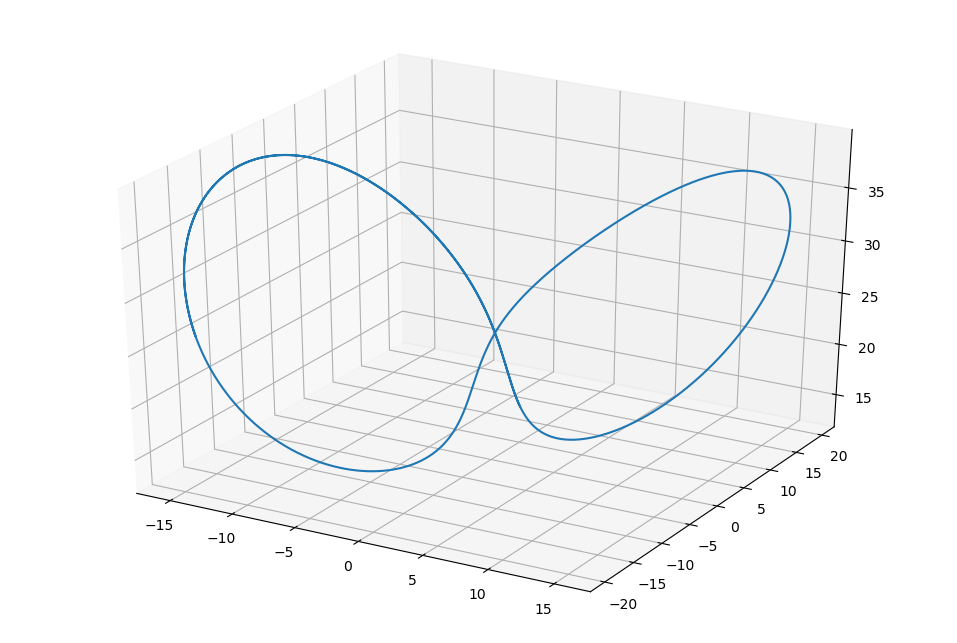

In [92]:
sol = RK4_s(gradient_s, x0, hr, nr)

fig = figure("Lorenz attractor",figsize=(12,8))
ax = fig[:add_subplot](1,1,1, projection = "3d")

ax[:plot3D](sol[1,:], sol[2,:], sol[3,:])
plt.show()

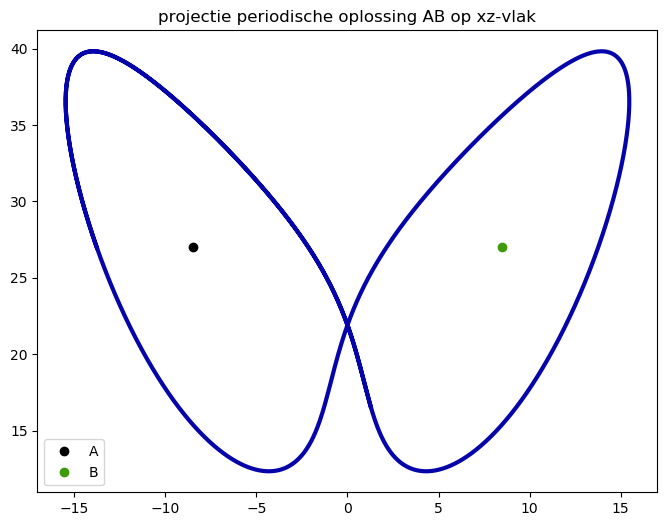

In [98]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

ax[:plot](sol[1,:], sol[3,:], "xkcd:royal blue", linewidth=3)
ax[:plot]([A[1]],[A[3]], "ok", label="A")
ax[:plot]([B[1]],[B[3]], "o", color="xkcd:grass green", label="B")
plt.title("projectie periodische oplossing AB op xz-vlak")
plt.legend()

plt.show()
fig[:savefig]("projectie_opdracht_3.pdf")

## Oefening 4

### functie om beginwaarde te benaderen

In [22]:
@everywhere begin
    #=
    deze functie zoekt de beginwaarde (y0) voor een periodische oplossing in een gegeven interval (guess_y0)
    voor gegeven waarden voor x0 en z0. het doet dit door oplossingen te berekenen met stapgrootte h, n punten
    en zoekt naar de dichtste waarde op het interval guess_I voor de iteratiestap.
    @Args:
    x0: x-waarde van de te zoeken beginwaarde
    y0: y-waarde van de te zoeken beginwaarde
    h: stapgrootte die gebruikt wordt om oplossingen te berekenen
    n: aantal iteratiestappen voor berekenen oplossing
    guess_y0: tuple(Float64), zoekt in dit interval naar de y-waarde van de beginwaarde
    guess_I: tuple, zoekt in de iteratiestappen in dit interval naar het dichtste punt bij het beginpunt
    rounds: het aantal rondes gebruikt om een betere benadering van de oplossing te bekomen
    @returns:
    lijst met steeds betere benaderingen van de beginwaarde + hoe dicht de oplossing bij de beginwaarde kwam
    =#
    function find_y0(x0, z0, h, n, guess_y0, guess_I, rounds)
        # initializeren variabelen
        H = fill(h, 5);
        N = fill(n, 5);
        GRAD = fill(gradient_s, 5);
        
        X0 = (0:4)/4 .* fill([0, guess_y0[2]-guess_y0[1], 0], 5) + fill([x0, guess_y0[1], z0], 5);
        sols = pmap(RK4_s, GRAD, X0, H, N);
        
        # in de for-loop worden slechts 2 oplossingen opnieuw berekend
        N = fill(n, 2);
        GRAD = fill(gradient_s, 2);
        
        # -------------------------------------
        # bereken de kleinste afstanden
        GUESS = fill(guess_I, 5);
        dists = pmap(find_closest, X0, sols, GUESS, H);
        GUESS = fill(guess_I, 2);
        H = fill(h, 2);
        
        dists = [d[2] for d in dists];
        best = minimum(dists);
        index = findfirst(isequal(best), dists);
        
        # sla de beginwaarde en bijhorende afstand op
        results = [];
        push!(results, [X0[index], best]);
        
        # -------------------------------------
        # refine the best guess 'rounds' times
        for i in 1:rounds
            # herbereken de beginwaarden en de 2 oplossingen rond het midden
            if index == 1
                index = index+1;
            elseif index == 5
                index = index-1;
            end
            # verander de plaats van de nieuwe eindpunten en het midden in de arrays
            # begin
            tempx1 = X0[index-1];
            temps1 = sols[index-1];
            tempd1 = dists[index-1];
            # midden
            tempx3 = X0[index];
            temps3 = sols[index];
            tempd3 = dists[index];

            # einde
            tempx5 = X0[index+1];
            temps5 = sols[index+1];
            tempd5 = dists[index+1];

            (X0[1], sols[1], dists[1]) = (tempx1, temps1, tempd1)
            (X0[3], sols[3], dists[3]) = (tempx3, temps3, tempd3)
            (X0[5], sols[5], dists[5]) = (tempx5, temps5, tempd5)
            
            # bereken de data voor de 2 nieuwe punten
            (X0[2], X0[4]) = ((X0[1] + X0[3])/2, (X0[5] + X0[3])/2);
            (sols[2], sols[4]) = pmap(RK4_s, GRAD, [X0[2], X0[4]], H, N);
            (temp2, temp4) = pmap(find_closest, [X0[2], X0[4]], [sols[2], sols[4]], GUESS, H);
            (dists[2], dists[4]) = (temp2[2], temp4[2]);
            
            # sla de nieuwe waarden op
            best = minimum(dists);
            index = findfirst(isequal(best), dists);
            push!(results, [X0[index], best]);
        end
        return results
    end
end

#### test functie in stukjes

In [145]:
x0 = -11.998523280062;
z0 = 27;
h = 1e-4;
T = 3.5;
n = ceil(Int64, T/h);
guess_y0 = [-15.7, -15.6];
guess_I = [29000, 32000];
rounds = 10;

In [129]:
# initializeren variabelen
H = fill(h, 5);
N = fill(n, 5);
GRAD = fill(gradient_s, 5);

X0 = (0:4)/4 .* fill([0, guess_y0[2]-guess_y0[1], 0], 5) + fill([x0, guess_y0[1], z0], 5);
sols = pmap(RK4_s, GRAD, X0, H, N);

In [130]:
# in de for-loop worden slechts 2 oplossingen opnieuw berekend
N = fill(n, 2);
GRAD = fill(gradient_s, 2);

# -------------------------------------
# bereken de kleinste afstanden
GUESS = fill(guess_I, 5);
dists = pmap(find_closest, X0, sols, GUESS, H);
GUESS = fill(guess_I, 2);
H = fill(h, 2);

In [131]:
dists = [d[2] for d in dists];
best = minimum(dists);
index = findfirst(isequal(best), dists);

# sla de beginwaarde en bijhorende afstand op
results = [];
push!(results, [X0[index], best]);

In [141]:
#for i in 1:rounds
    println(X0)
    # herbereken de beginwaarden en de 2 oplossingen rond het midden
    if index == 1
        index = index+1;
    elseif index == 5
        index = index-1;
    end
    # verander de plaats van de nieuwe eindpunten en het midden in de arrays
    # begin
    tempx1 = X0[index-1];
    temps1 = sols[index-1];
    tempd1 = dists[index-1];
    # midden
    tempx3 = X0[index];
    temps3 = sols[index];
    tempd3 = dists[index];
    
    # einde
    tempx5 = X0[index+1];
    temps5 = sols[index+1];
    tempd5 = dists[index+1];
    
    (X0[1], sols[1], dists[1]) = (tempx1, temps1, tempd1)
    (X0[3], sols[3], dists[3]) = (tempx3, temps3, tempd3)
    (X0[5], sols[5], dists[5]) = (tempx5, temps5, tempd5)

    # bereken de data voor de 2 nieuwe punten
    (X0[2], X0[4]) = ((X0[1] + X0[3])/2, (X0[5] + X0[3])/2);
    (sols[2], sols[4]) = pmap(RK4_s, GRAD, [X0[2], X0[4]], H, N);
    (temp2, temp4) = pmap(find_closest, [X0[2], X0[4]], [sols[2], sols[4]], GUESS, H);
    (dists[2], dists[4]) = (temp2[2], temp4[2]);

    # sla de nieuwe waarden op
    best = minimum(dists);
    index = findfirst(isequal(best), dists);
    push!(results, [X0[index], best]);
#end

Array{Float64,1}[[-11.9985, -15.6848, 27.0], [-11.9985, -15.6846, 27.0], [-11.9985, -15.6844, 27.0], [-11.9985, -15.6842, 27.0], [-11.9985, -15.684, 27.0]]


In [148]:
find_y0(x0, z0, h, n, guess_y0, guess_I, 15)

16-element Array{Any,1}:
 Any[[-11.9985, -15.675, 27.0], 0.134033]    
 Any[[-11.9985, -15.6875, 27.0], 0.0462388]  
 Any[[-11.9985, -15.6812, 27.0], 0.0430462]  
 Any[[-11.9985, -15.6844, 27.0], 0.00172153] 
 Any[[-11.9985, -15.6844, 27.0], 0.00172153] 
 Any[[-11.9985, -15.6844, 27.0], 0.00172153] 
 Any[[-11.9985, -15.6844, 27.0], 0.00172153] 
 Any[[-11.9985, -15.6842, 27.0], 0.00106117] 
 Any[[-11.9985, -15.6843, 27.0], 0.000330167]
 Any[[-11.9985, -15.6843, 27.0], 0.000330167]
 Any[[-11.9985, -15.6843, 27.0], 1.75893e-5] 
 Any[[-11.9985, -15.6843, 27.0], 1.75893e-5] 
 Any[[-11.9985, -15.6843, 27.0], 1.75893e-5] 
 Any[[-11.9985, -15.6843, 27.0], 1.75893e-5] 
 Any[[-11.9985, -15.6843, 27.0], 4.14657e-6] 
 Any[[-11.9985, -15.6843, 27.0], 4.14657e-6] 

### test

In [23]:
# definieer bereik stapgroottes om te testen
num = 9
iter = 1:num
h = fill(1e-4, num)
T = 4
n = ceil.(Int64, T ./ h)
# definieer de beginvoorwaarden
x1 = [-11.998523280062, -16, 27]
step = 1/8
X = fill([0, step, 0], num) .* (0:(num-1)) .+ fill(x1, num)
# los de differentiaalvergelijkingen op
sol = pmap(RK4_s, fill(gradient_s, num), X, h, n);

b0 = fill.(X, n)
sols = [[sol[i][:,j] for j in 1:n[i]] for i in iter]
dists = [pmap(norm, b0[i]-sols[i]) for i in iter];

In [31]:
dists_init = [dists[i][1:31000] for i in iter];

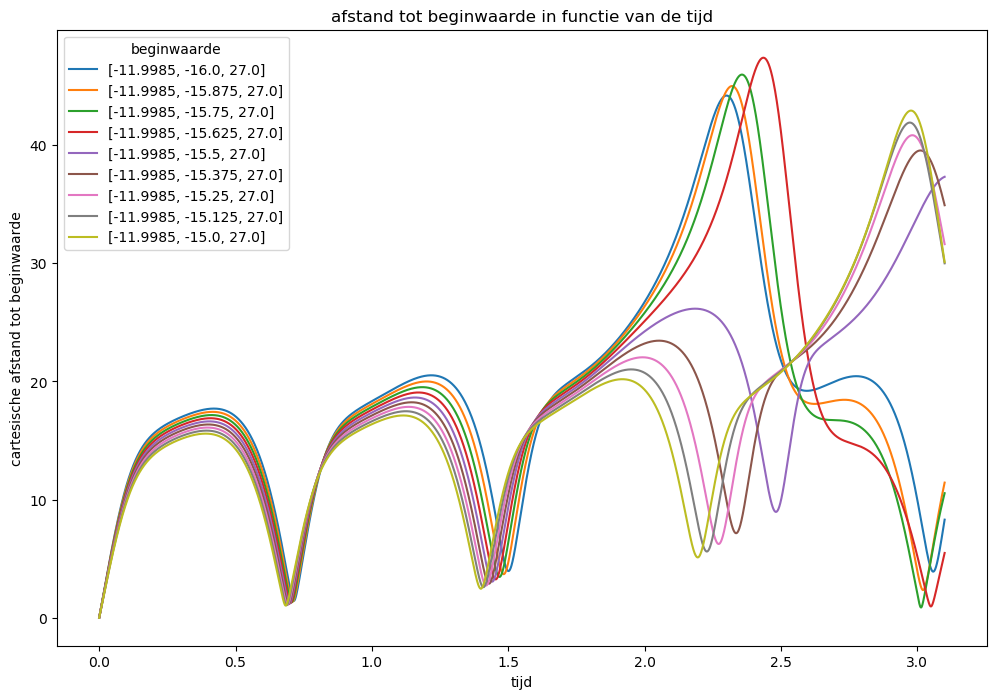

In [30]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

plot_range = 1:31000
for i in iter
    ax[:plot](plot_range/1e4, dists_init[i][plot_range], label="$(X[i])")
end

plt.legend(title="beginwaarde")
plt.title("afstand tot beginwaarde in functie van de tijd")
ax[:set_xlabel]("tijd")
ax[:set_ylabel]("cartesische afstand tot beginwaarde")
fig[:savefig]("afstand tot beginwaarde-exploratie.pdf", dpi=400)
plt.show()

We zien dat de rode, groene en oranje curve het dichtst in de buurt komen van het gewenste gedrag. We zoeken dus verder in de buurt van deze beginwaarden

### zoek de juiste beginwaarde

In [38]:
# initialiseer de beginwaarden en parameters voor de functie
x0 = -11.998523280062;
z0 = 27;
h = 1e-4;
n = 32001;
guess_y0 = [-15.7, -15.6];
guess_I = [29000, 32000];
rounds = 15;

In [39]:
# zoek een zo goed mogelijke benadering, de fout zal met een stapgrootte van 1e-4
# niet veel kleiner dan 1e-5 kunnen worden
results = find_y0(x0, z0, h, n, guess_y0, guess_I, rounds);
results[rounds][2]

4.146571768813626e-6

Print de periode en beginwaarde met hoge precisie

In [40]:
@printf("Beginwaarde: y(0) = %.8f, periode: T = %.8f", results[rounds][1][2], 5)

Beginwaarde: y(0) = -15.68425446, periode: T = 5.00000000

### Plots voor verslag

In [41]:
# verwijder de dubbels
results = unique(results);

In [42]:
# vind de opeenvolgende oplossingen
num = 8
iter = 1:num

X = [result[1] for result in results]
h = fill(1e-4, num)
n = fill(32001, num)
GRAD = fill(gradient_s, num)
sol = pmap(RK4_s, GRAD, X, h, n);
# vind de afstanden tot de beginwaarde
b0 = fill.(X, n)
sols = [[sol[i][:,j] for j in 1:n[i]] for i in iter]
dists = [pmap(norm, b0[i]-sols[i]) for i in iter];

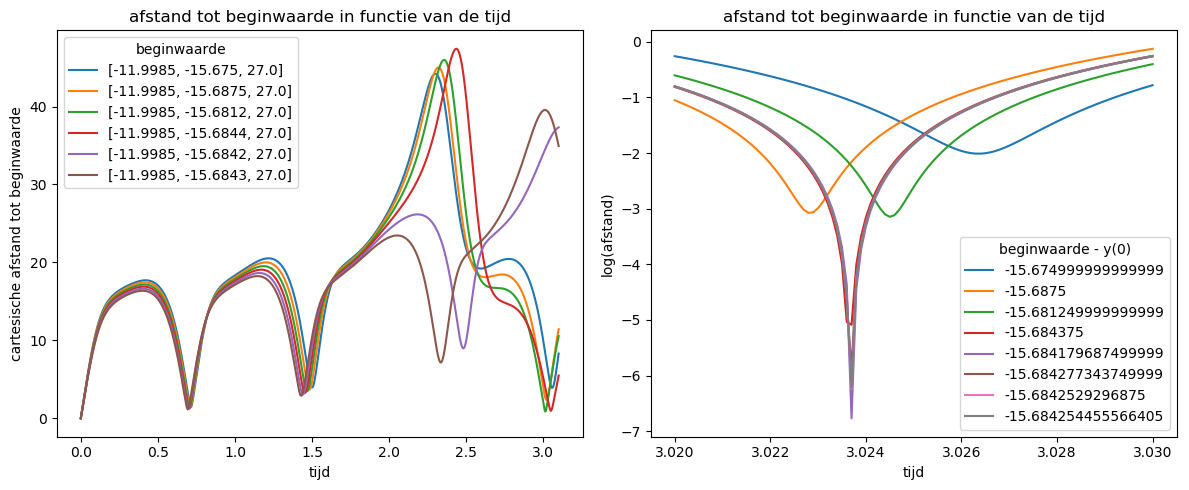

In [52]:
fig = plt.figure("benaderen beginwaarde", figsize=(12,5))

# eerste gokken verspreid over interval
ax = fig[:add_subplot](1,2,1)
plot_range = 1:31000
for i in 1:6
    ax[:plot](plot_range/1e4, dists_init[i][plot_range], label="$(X[i])")
end
plt.legend(title="beginwaarde")
plt.title("afstand tot beginwaarde in functie van de tijd")
ax[:set_xlabel]("tijd")
ax[:set_ylabel]("cartesische afstand tot beginwaarde")

#---------------------------------------------------------
# fout op iteratiestappen rond T

ax = fig[:add_subplot](1,2,2)
plot_range = 30200:30300
for i in iter
    ax[:plot](plot_range/1e4, log.(dists[i][plot_range]), label="$(results[i][1][2])")
end

plt.legend(title="beginwaarde - y(0)")
plt.title("afstand tot beginwaarde in functie van de tijd")
ax[:set_xlabel]("tijd")
ax[:set_ylabel]("log(afstand)")

plt.show()
fig[:tight_layout]()

fig[:savefig]("afstand_beginwaarde_opdracht4.pdf", dpi=400)

Plot oplossing

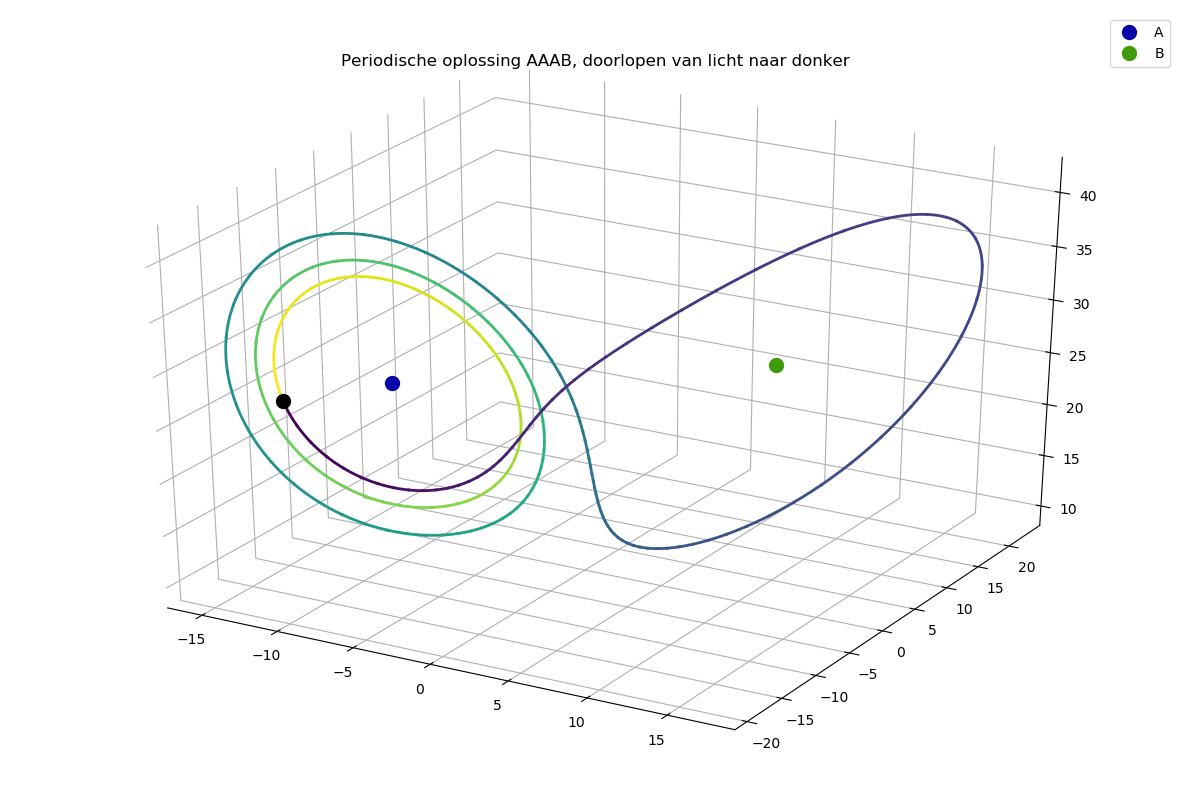

In [88]:
X = sol[8][1,:];
Y = sol[8][2,:];
Z = sol[8][3,:];

fig = figure("Lorenz attractor",figsize=(12, 8))
ax = fig[:add_subplot](1,1,1, projection = "3d")

len = 30200
num = 200
ran = 0:0.005:995
stap = floor(Int64, len / num)
c = mpl.cm[:viridis](ran)
#c = mpl.cm[:plasma](ran)

for i in 1:num
    ax[:plot3D](X[(i-1)*stap+1:i*stap], Y[(i-1)*stap+1:i*stap], Z[(i-1)*stap+1:i*stap], c=c[201-i,:], linewidth=2)
end
ax[:plot3D]([X[1]], [Y[1]], [Z[1]], "ok", markersize=10)
ax[:plot3D]([A[1]], [A[2]], [A[3]], "o", markersize=10, color="xkcd:royal blue", label="A")
ax[:plot3D]([B[1]], [B[2]], [B[3]], "o", markersize=10, color="xkcd:grass green", label="B")
#ax[:plot3D]([O[1]], [O[2]], [O[3]], "o", markersize=10, color="xkcd:maroon", label="O")

ax[:xaxis][:set_pane_color]((1,1,1,0))
ax[:yaxis][:set_pane_color]((1,1,1,0))
ax[:zaxis][:set_pane_color]((1,1,1,0))
plt.legend()
plt.title("Periodische oplossing AAAB, doorlopen van licht naar donker")
fig[:tight_layout]()

plt.show()

fig[:savefig]("peiodische_baan_AAAB_opdracht4.pdf")

### Exactere benadering met kleinere stapgrootte

In [20]:
# zoek een betere benadering van de beginwaarde door een kleinere h te nemen
h = 1e-5
n = 320001
guess_I = [290000, 320000]
rounds = 25
results = find_y0(x0, z0, h, n, guess_y0, guess_I, rounds);
results[rounds][2]

2.4886188244557686e-9

In [21]:
# verwijder de dubbels
results = unique(results)

11-element Array{Any,1}:
 Any[[-11.9985, -15.675, 27.0], 0.133929]    
 Any[[-11.9985, -15.6875, 27.0], 0.0460466]  
 Any[[-11.9985, -15.6812, 27.0], 0.0430315]  
 Any[[-11.9985, -15.6844, 27.0], 0.00173045] 
 Any[[-11.9985, -15.6842, 27.0], 0.00115211] 
 Any[[-11.9985, -15.6843, 27.0], 0.000331388]
 Any[[-11.9985, -15.6843, 27.0], 1.66568e-5] 
 Any[[-11.9985, -15.6843, 27.0], 5.09718e-6] 
 Any[[-11.9985, -15.6843, 27.0], 3.41339e-7] 
 Any[[-11.9985, -15.6843, 27.0], 3.38495e-7] 
 Any[[-11.9985, -15.6843, 27.0], 2.48862e-9] 

Maak een plot van de opeenvolgende benaderingen, de cel hieronder wil je niet opnieuw runnen :p

In [25]:
# vind de opeenvolgende oplossingen
num = 11
iter = 1:num

X = [result[1] for result in results]
h = fill(1e-5, num)
n = fill(320001, num)
GRAD = fill(gradient_s, num)
sol = pmap(RK4_s, GRAD, X, h, n);
# vind de afstanden tot de beginwaarde
b0 = fill.(X, n)
sols = [[sol[i][:,j] for j in 1:n[i]] for i in iter]
dists = [pmap(norm, b0[i]-sols[i]) for i in iter];

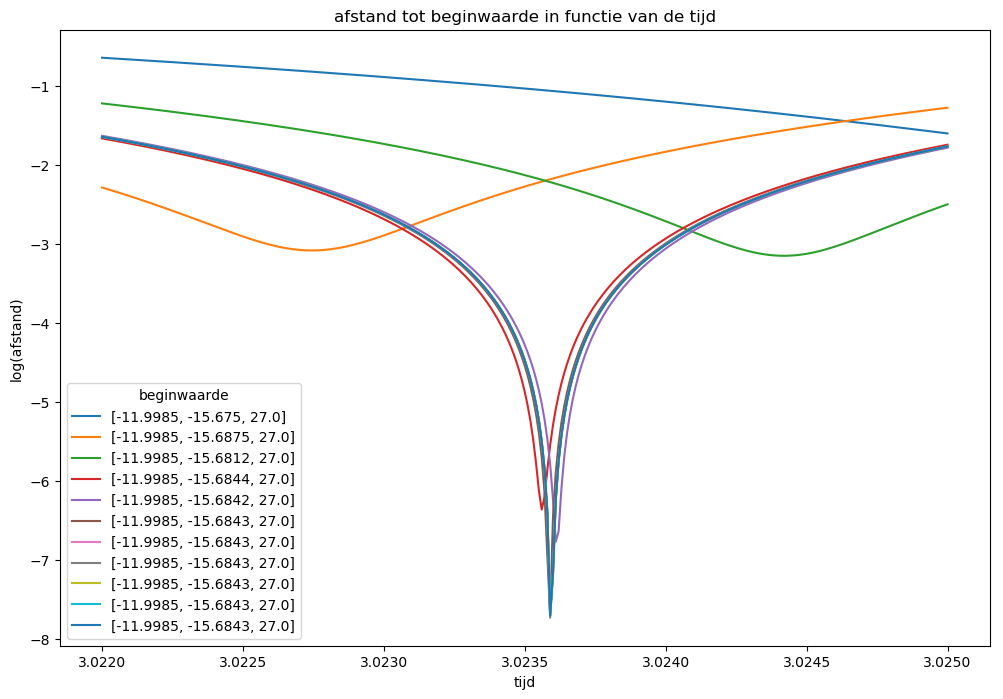

In [26]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

plot_range = 302200:302500
for i in iter
    ax[:plot](plot_range/1e5, log.(dists[i][plot_range]), label="$(results[i][1])")
end

plt.legend(title="beginwaarde")
plt.title("afstand tot beginwaarde in functie van de tijd")
ax[:set_xlabel]("tijd")
ax[:set_ylabel]("log(afstand)")
fig[:savefig]("afstand tot beginwaarde - nauwkeurig.pdf", dpi=400)
plt.show()

## Oefening 5

Bereken een beginwaarde die in het vlak ligt waarnaar de oplossingen rond A worden getrokken. De vergelijking van dit vlak kunnen we schrijven als: $$(\vec{x}-\vec{A}) \cdot \vec{v_1} = 0$$ Als we $z$ i.f.v. $x$ en $y$ schrijven wordt dit: $$z = \frac{-v_x(x-a_x)-v_y(y-a_y)}{v_z} + a_z$$

In [16]:
v = eigA.vectors[:,1]
a = np.matrix(A, dtype=np.float64)
z_val(x, y) = (-v[1]*(x-a[1])-v[2]*(y-a[2]))/v[3] + a[3]

z_val (generic function with 1 method)

### plot over lange tijd

In [219]:
sp.pprint(A)
# kies een beginwaarde in de buurt van A
num=5
x0 = [[-10 - i, -10 - i, z_val(-10 - i, -10 - i)] for i in 0:num];

(-8.48528137423857, -8.48528137423857, 27.0)


In [220]:
h = fill(1e-4, num+1)
T = 500
n = ceil.(Int64, T./h)
sol = pmap(RK4_s, fill(gradient_s, num+1), x0, h, n);

Kies een interessante plot

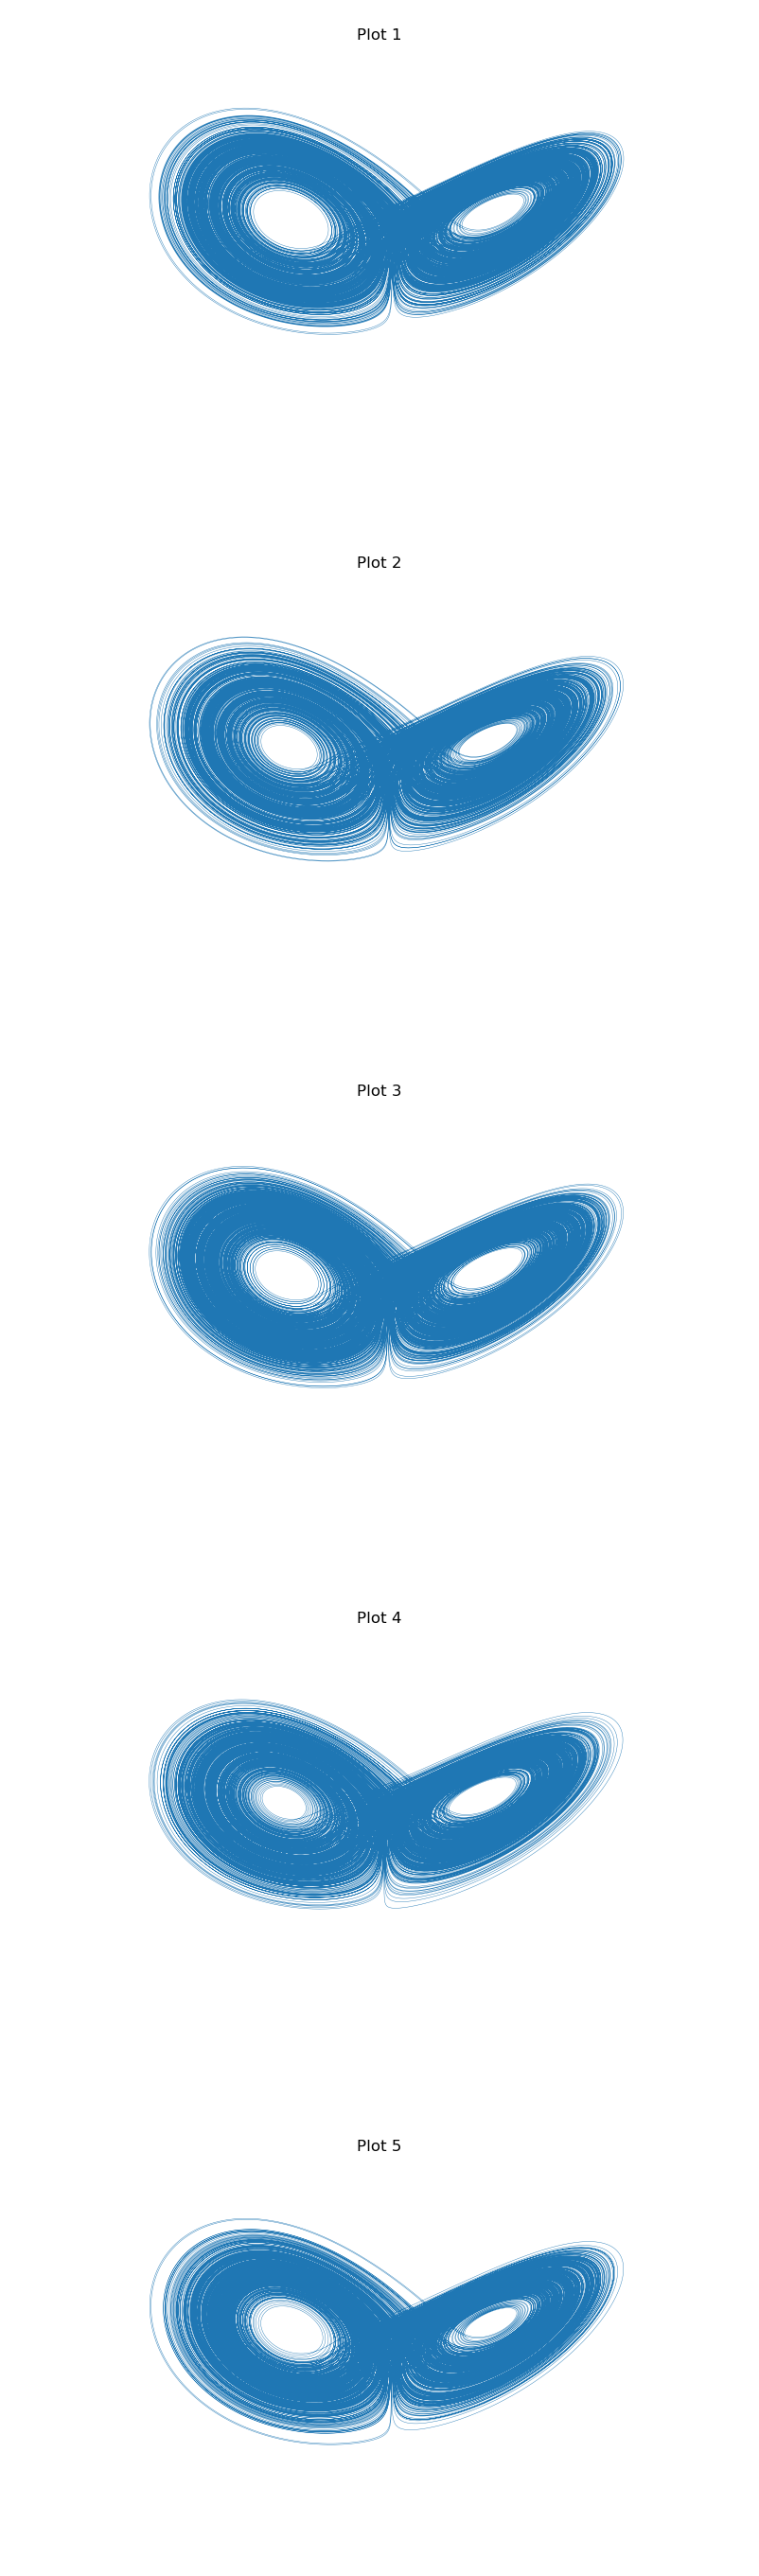

In [221]:
fig = figure("Lorenz attractor",figsize=(10, 7*num))
ax = fig[:add_subplot](num,1,num, projection = "3d")

for i in 1:num
    ax = fig[:add_subplot](num,1,i, projection = "3d")
    ax[:plot3D](sol[i][1,:], sol[i][2,:], sol[i][3,:], linewidth=0.3)
    ax[:set_title]("Plot $i")
    plt.axis("off")
end

plt.show()
#fig[:savefig]("10 Lorenz Attractors.pdf", dpi=600)

Maak een plot met de projecties op de coördinaatvlakken en de 3D-prjectie

**Plot voor in verslag**

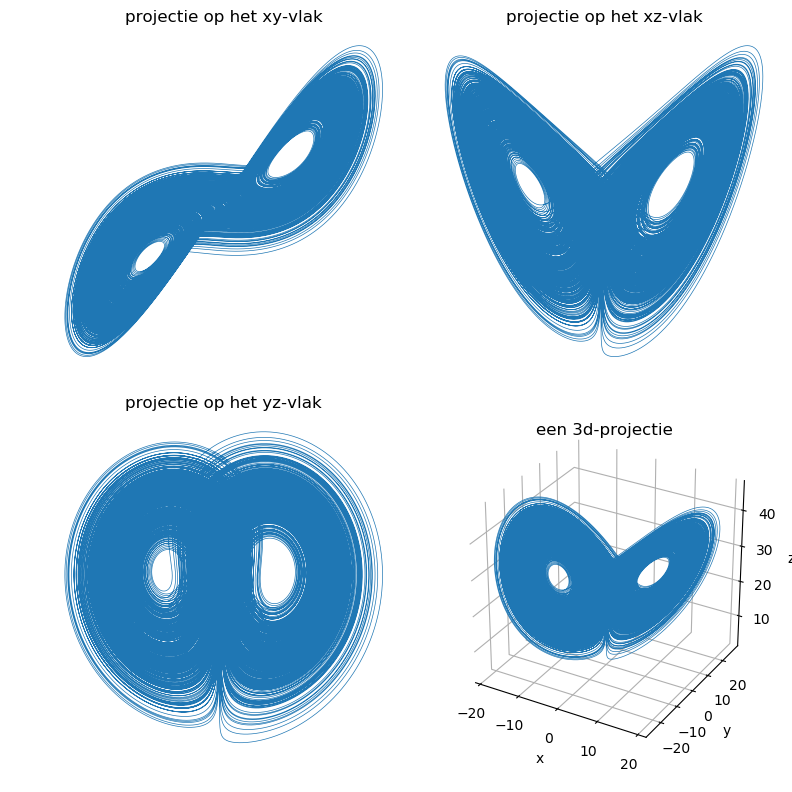

In [242]:
fig =figure("Lorenz Attractor", figsize=(8, 8))

X = sol[4][1,:]
Y = sol[4][2,:]
Z = sol[4][3,:]

# projectie op xy-vlak
ax = fig[:add_subplot](2,2,1)
ax[:plot](X, Y, linewidth=0.5)
ax[:set_title]("projectie op het xy-vlak")
plt.axis("off")

# projectie op xz-vlak
ax = fig[:add_subplot](2,2,2)
ax[:plot](X, Z, linewidth=0.5)
ax[:set_title]("projectie op het xz-vlak")
plt.axis("off")

# projectie op yz-vlak
ax = fig[:add_subplot](2,2,3)
ax[:plot](Y, Z, linewidth=0.5)
ax[:set_title]("projectie op het yz-vlak")
plt.axis("off")

# een 3D-projectie
ax = fig[:add_subplot](2,2,4, projection = "3d")
ax[:plot3D](X, Y, Z, linewidth=0.5)
ax[:set_title]("een 3d-projectie")
ax[:set_xlabel]("x")
ax[:set_ylabel]("y")
ax[:set_zlabel]("z")
ax[:xaxis][:set_pane_color]((1,1,1,0))
ax[:yaxis][:set_pane_color]((1,1,1,0))
ax[:zaxis][:set_pane_color]((1,1,1,0))
#plt.axis("off")

fig[:tight_layout](pad=1, w_pad=0, h_pad=0)
plt.show()

fig[:savefig]("Projecties Lorenz Attractor, T groot.pdf")

### plot met colorgradient

In [209]:
sp.pprint(A)
# kies een beginwaarde in de buurt van A
num=5
x0 = [[-10 - i, -10 - i, z_val(-10 - i, -10 - i)] for i in 0:num];

(-8.48528137423857, -8.48528137423857, 27.0)


In [210]:
h = fill(1e-4, num+1)
T = 5
n = ceil.(Int64, T./h)
sol = pmap(RK4_s, fill(gradient_s, num+1), x0, h, n);

Kies een interessante oplossing

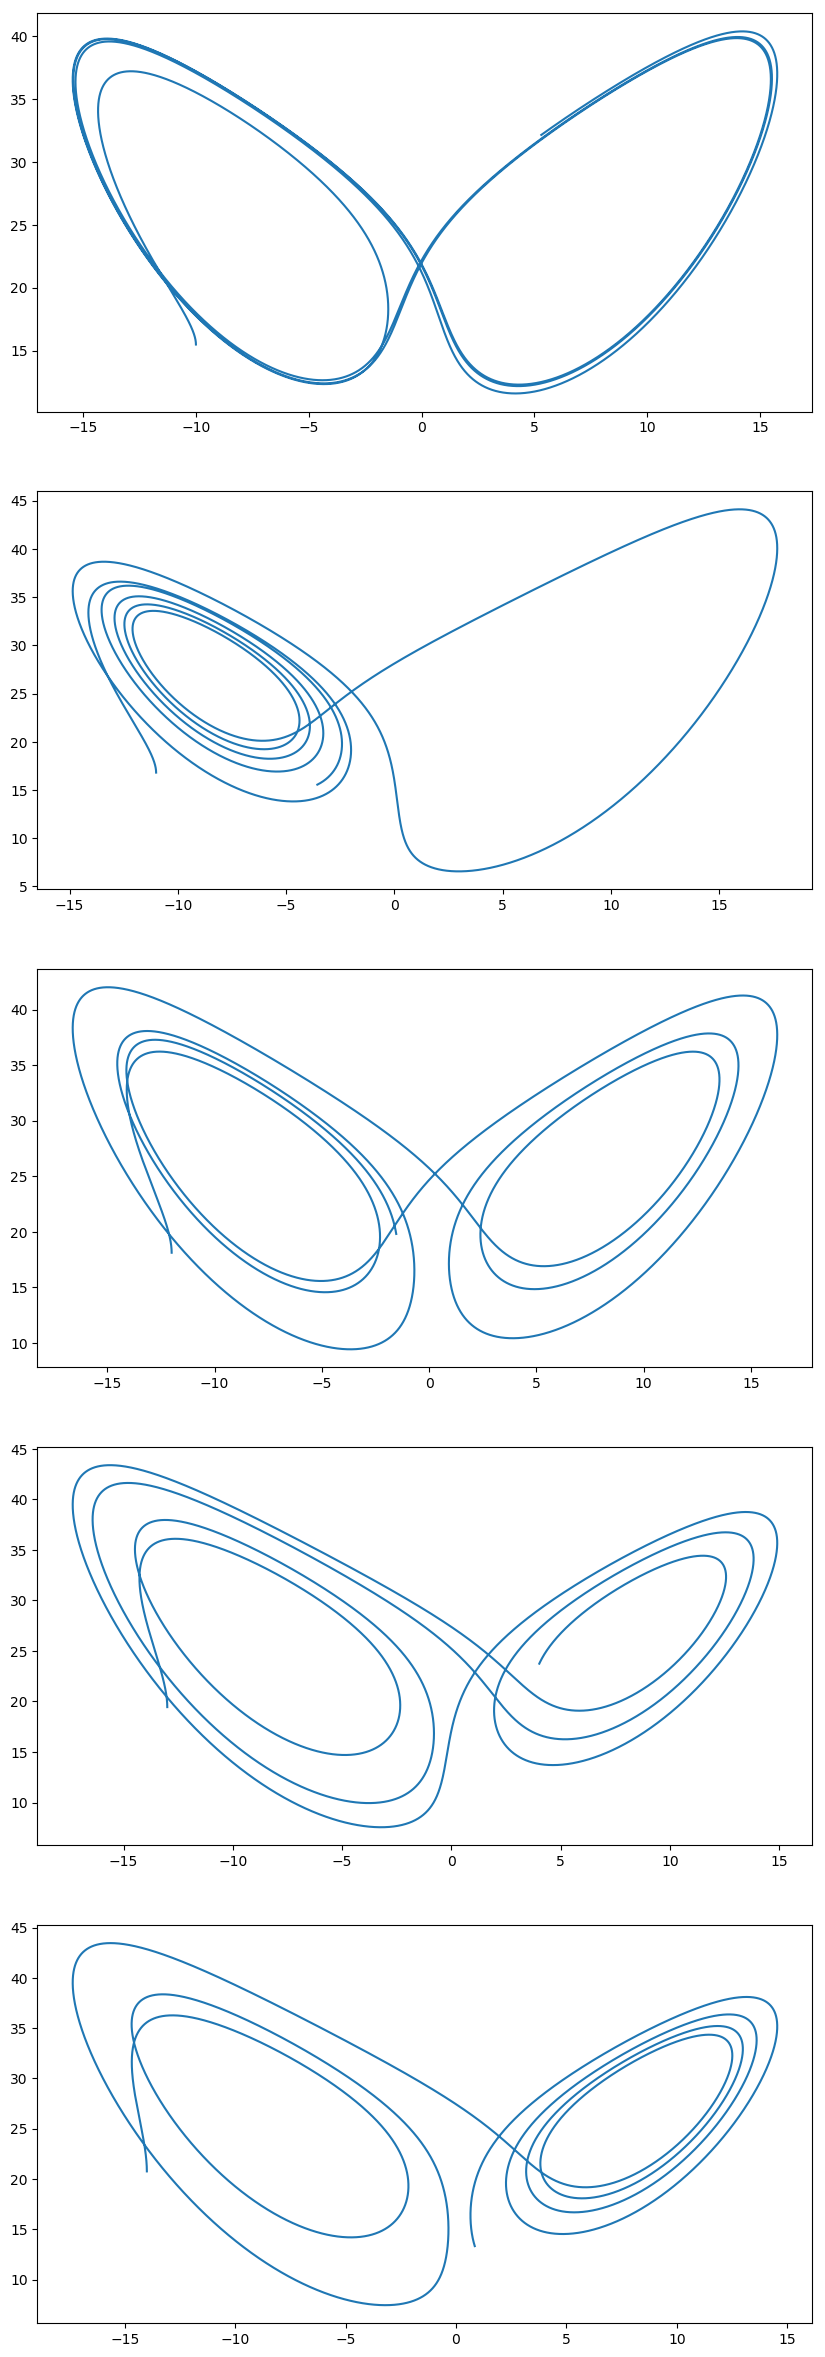

In [211]:
# plot de oplossingen
fig, ax = plt.subplots(num,1, figsize=(10, 6*num))

plot_range = 1:10000*T
for i in 1:num
    ax[i][:plot](sol[i][1,:], sol[i][3,:])
end

plt.show()

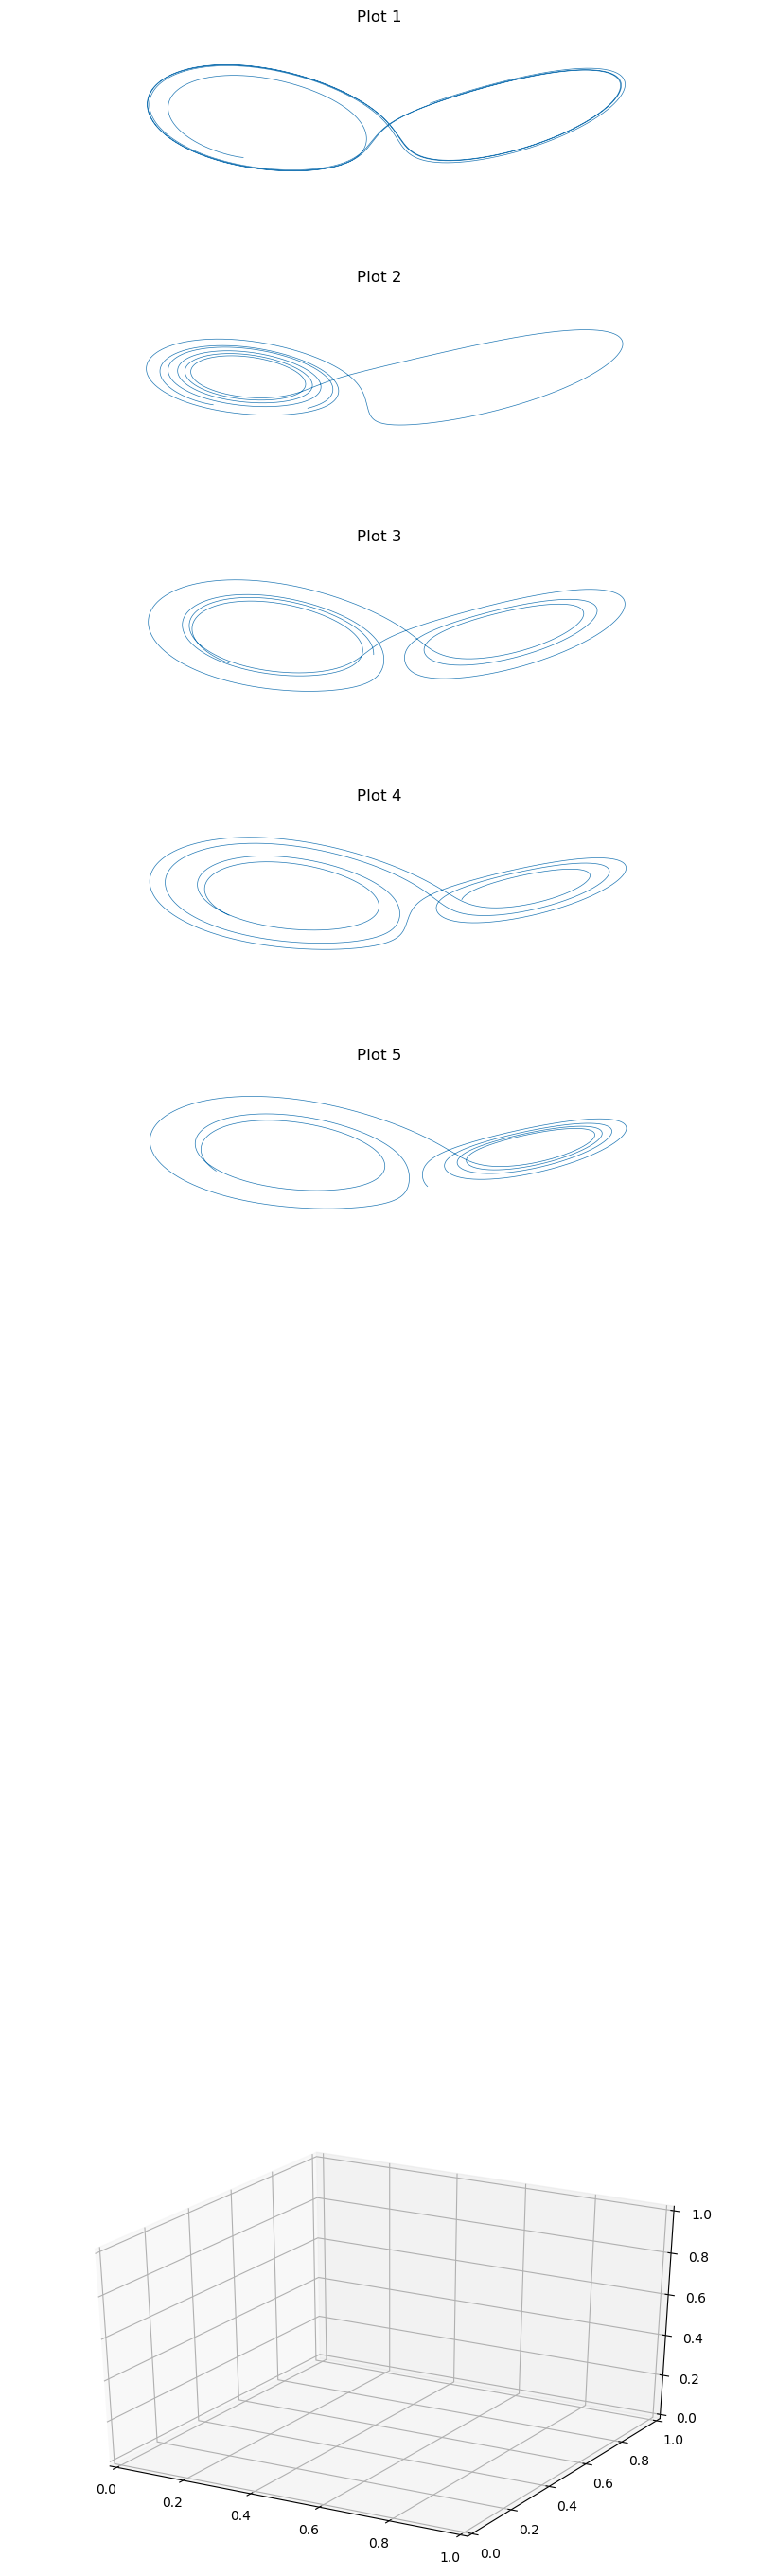

In [213]:
fig = figure("Lorenz attractor",figsize=(10, 7*num))
ax = fig[:add_subplot](num,1,num, projection = "3d")

for i in 1:num
    ax = fig[:add_subplot](num,1,i, projection = "3d")
    ax[:plot3D](sol[i][1,:], sol[i][2,:], sol[i][3,:], linewidth=0.5)
    ax[:set_title]("Plot $i")
    plt.axis("off")
end

plt.show()
#fig[:savefig]("10 Lorenz Attractors.pdf", dpi=600)

Maak een plot met kleurgradiënt ifv de tijd, waar de kleur snel verandert, is de afgeleide klein en omgekeerd

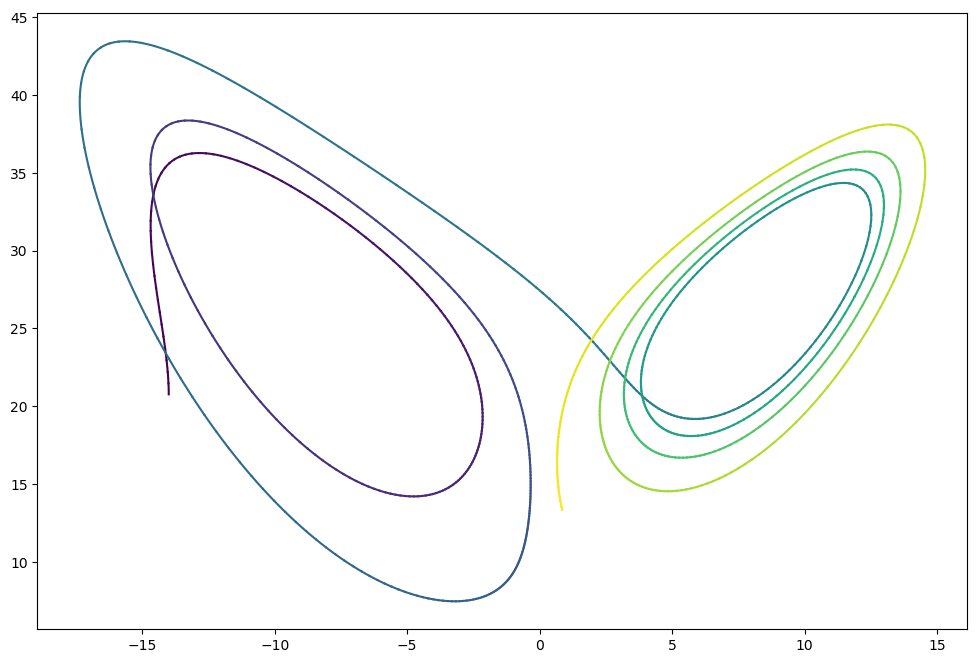

In [216]:
curve_num = 5
X = sol[curve_num][1,:]
Y = sol[curve_num][3,:]
t = 1:n[curve_num]
len = n[curve_num]
num = 1000
ran = 0:0.001:999
stap = floor(Int64, len / num)

c = mpl.cm[:viridis](ran)
#c = mpl.cm[:plasma](ran)

fig, ax = plt.subplots(1,1, figsize=(12, 8))

for i in 1:num
    ax[:plot](X[(i-1)*stap+1:i*stap], Y[(i-1)*stap+1:i*stap], c=c[i,:])
end

plt.show()

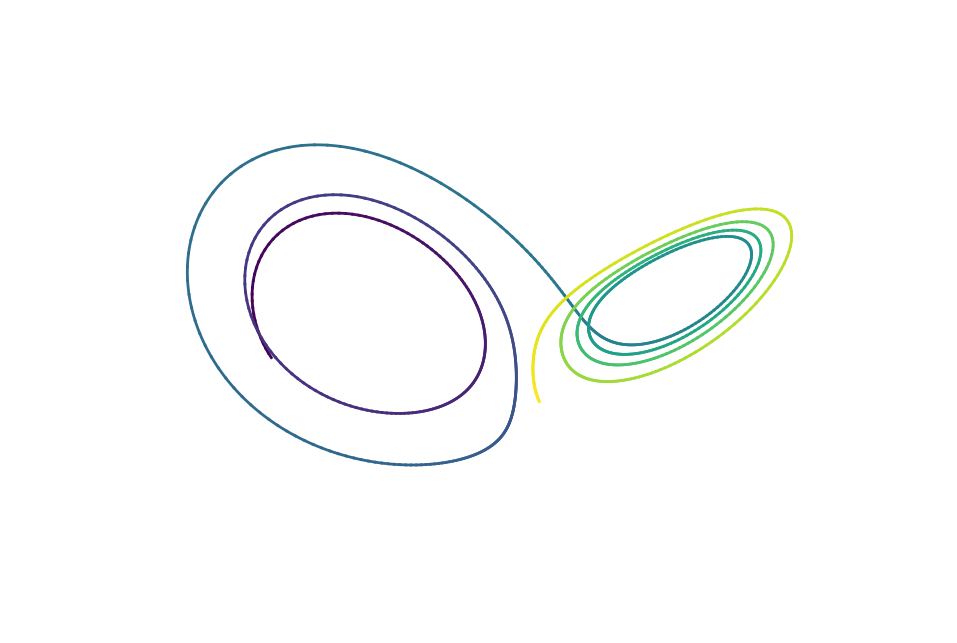

In [218]:
curve_num = 5
X = sol[curve_num][1,:]
Y = sol[curve_num][2,:]
Z = sol[curve_num][3,:]
len = n[curve_num]
num = 1000
ran = 0:0.001:999
stap = floor(Int64, len / num)

c = mpl.cm[:viridis](ran)
#c = mpl.cm[:plasma](ran)

fig = figure("Lorenz attractor",figsize=(12, 8))
ax = fig[:add_subplot](1,1,1, projection = "3d")

for i in 1:num
    ax[:plot3D](X[(i-1)*stap+1:i*stap], Y[(i-1)*stap+1:i*stap], Z[(i-1)*stap+1:i*stap], c=c[i,:], linewidth=2)
end

#=
ax[:xaxis][:set_pane_color]((1,1,1,0))
ax[:yaxis][:set_pane_color]((1,1,1,0))
ax[:zaxis][:set_pane_color]((1,1,1,0))
ax[:axes][:grid](false)
=#
plt.axis("off")

plt.show()

## Plot 

In [22]:
x0 = [-9, -9, z_val(-9, -9)]
h = 1e-4
T = 100
n = ceil(Int64, T/h)
sol = RK4_s(gradient_s, x0, h, n);

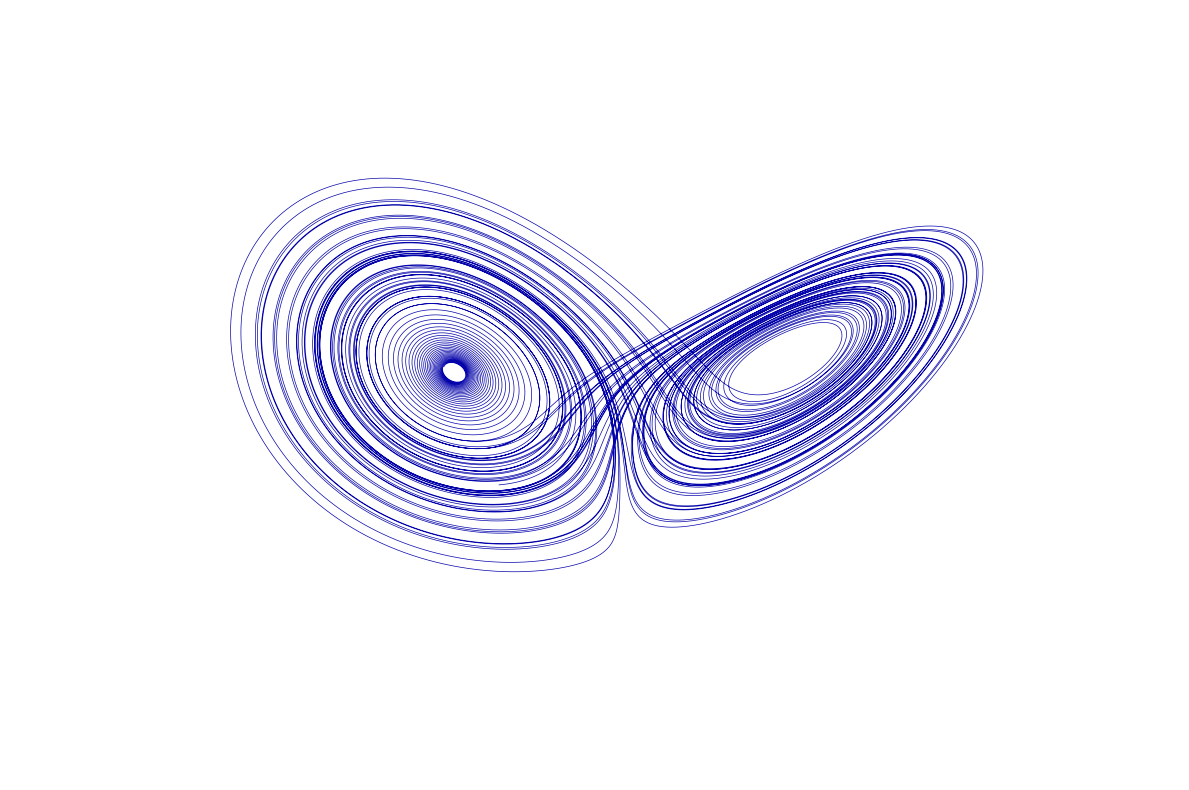

In [26]:
fig = plt.figure("blabla", figsize=(12, 8))

ax = fig[:add_subplot](1,1,1, projection="3d")

ax[:plot](sol[1,:], sol[2,:], sol[3,:], color="xkcd:royal blue", linewidth=0.5)

plt.axis("off")
fig[:tight_layout]()
plt.show()